# FINM 35910 - Homework 2
## Harrison Holt

## Setup

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
import pandas_ta as ta
import seaborn as sn
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import sklearn
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [6]:
df = pd.read_parquet('Data/crypto.parquet')
data = df.loc[df.index >= '2022-01-01']

In [7]:
close_prices = data[['BTC_Close','ETH_Close']]
btc_data = data[['BTC_Close','BTC_Trades']].copy()
btc_data['BTC_Returns'] = btc_data['BTC_Close'].pct_change()

In [8]:
btc_data.head()

,BTC_Close,BTC_Trades,BTC_Returns
timestamp,,,
2022-01-01 00:00:00+00:00,46230.0,335,NaN
2022-01-01 00:01:00+00:00,46248.8,6,0.000407
2022-01-01 00:02:00+00:00,46329.9,18,0.001754
2022-01-01 00:03:00+00:00,46307.9,8,-0.000475
2022-01-01 00:05:00+00:00,46405.3,105,0.002103


In [9]:
def pairs_trading_signal(entry_threshold, exit_threshold, rolling_window):
    scaler = StandardScaler()
    norm_prices = pd.DataFrame(data=scaler.fit_transform(close_prices.values), columns=close_prices.columns, index=close_prices.index)


    norm_prices['price_ratio'] = norm_prices['BTC_Close'] / norm_prices['ETH_Close']
    norm_prices['z_score'] = (norm_prices['price_ratio'] - norm_prices['price_ratio'].rolling(rolling_window).mean()) / norm_prices['price_ratio'].rolling(120).std()

    # norm_prices['Price_Ratio_Signal'] = 0

    # norm_prices.loc[norm_prices['z_score'] > entry_threshold, 'Price_Ratio_Signal'] = -1 # Short signal (sell BTC, buy ETH)
    # norm_prices.loc[norm_prices['z_score'] < -entry_threshold, 'Price_Ratio_Signal'] = 1 # Long signal (buy BTC, sell ETH)
    # norm_prices.loc[norm_prices['z_score'].abs() < exit_threshold, 'Price_Ratio_Signal'] = 0 # Exit signal

    return norm_prices['z_score'].values

def add_trading_features(data):
    df = data.copy()

    feature_cols = []
    fund = 'BTC'
    sma_list = [str(i) for i in range(10,91,10)]
    
    for interval in sma_list:
            # Calculate moving average
            # df[fund + "_" + interval] = df[fund + "_Close"].rolling(int(interval)).mean() # For simple moving averages
            df["EWMA_" + interval] = df[fund + "_Close"].ewm(span=int(interval), adjust=False).mean() # For exponential moving averages
            feature_cols.append("EWMA_" + interval)
            # # Calculate difference between month end price and moving average
            # df["EWMA" + "_" + interval] = df[fund + "_Close"] - df["EWMA" + "_" + interval]

            # # Generate binary output on whether month end price is greater or less than moving average
            # df["EWMA" + "_" + interval + "_Sig"] = np.where(df[fund + "_Close"] > df["EWMA" + "_" + interval], 1, 0)

            # # Generate diff from binary output above
            # df["EWMA" + "_" + interval + "_Sig_Change"] = df["EWMA" + "_" + interval + "_Sig"].diff()

            # # Generate order from diff above
            # col = 'EWMA' + "_" + interval + "_Sig_Change"
            # conditions = [df[col] == 1, df[col] == 0, df[col] == -1]
            # choices = [1, 0, -1]

            # # df[fund + "_" + interval + "_Action"] = np.select(conditions, choices, default=np.nan)
            # df['EWMA' + "_" + interval] = np.select(conditions, choices, default=None)
            
            # drop_cols = [col for col in df.columns if 'Sig' in col]
            # df.drop(drop_cols, axis=1, inplace=True)
    
    df['Price_Ratio_Signal'] = pairs_trading_signal(entry_threshold=1.00, exit_threshold=0.30, rolling_window=120)
    feature_cols.append('Price_Ratio_Signal')

    def f(x):
        if x > 0.0001:
            return 1
        elif x < -0.00001:
            return -1
        else:
            return 0

    df[fund+'_Returns_Shift'] = df['BTC_Returns'].shift(-1)
    df = df.dropna()
    y_binary = df[fund+'_Returns_Shift'].apply(f)
    print(feature_cols)
    X = df[feature_cols].copy()
    
    return X, y_binary, df

## Random Forests
### Cross validation parameters

In [10]:
prep_data_tuple = add_trading_features(btc_data)
prep_df = prep_data_tuple[2].copy()
prep_df.head(5)

['EWMA_10', 'EWMA_20', 'EWMA_30', 'EWMA_40', 'EWMA_50', 'EWMA_60', 'EWMA_70', 'EWMA_80', 'EWMA_90', 'Price_Ratio_Signal']


,BTC_Close,BTC_Trades,BTC_Returns,EWMA_10,EWMA_20,EWMA_30,EWMA_40,EWMA_50,EWMA_60,EWMA_70,EWMA_80,EWMA_90,Price_Ratio_Signal,BTC_Returns_Shift
timestamp,,,,,,,,,,,,,,
2022-01-01 03:12:00+00:00,46844.7,4,0.000160,46809.215164,46805.990848,46804.990253,46800.180785,46791.005201,46778.395534,46763.524835,46747.385045,46730.705909,1.187280,0.000002
2022-01-01 03:13:00+00:00,46844.8,2,0.000002,46815.685134,46809.686958,46807.558624,46802.357332,46793.114801,46780.572729,46765.814276,46749.790353,46733.213472,1.147874,0.000000
2022-01-01 03:15:00+00:00,46844.8,6,0.000000,46820.978746,46813.031057,46809.961293,46804.427706,46795.141672,46782.678541,46768.039226,46752.136270,46735.665923,1.105759,0.000768
2022-01-01 03:16:00+00:00,46880.8,16,0.000768,46831.855338,46819.485242,46814.531532,46808.153184,46798.500822,46785.895638,46771.215586,46755.313152,46738.855683,1.199996,0.000096
2022-01-01 03:17:00+00:00,46885.3,3,0.000096,46841.572549,46825.753314,46819.097240,46811.916443,46801.904711,46789.154798,46774.429231,46758.522704,46742.074239,1.227697,0.000002


In [11]:
df_train = prep_df.loc['2022-01-01':'2024-03-31'].dropna()
df_valid = prep_df.loc['2024-04-01':'2024-06-30'].dropna()
df_test = prep_df.loc['2024-07-01':'2024-09-30'].dropna()

In [23]:
train = df_train.reset_index().drop(['timestamp','BTC_Close','BTC_Trades','BTC_Returns','BTC_Returns_Shift'], axis=1).copy()
valid = df_valid.reset_index().drop(['timestamp','BTC_Close','BTC_Trades','BTC_Returns','BTC_Returns_Shift'], axis=1).copy()
test = df_test.reset_index().drop(['timestamp','BTC_Close','BTC_Trades','BTC_Returns','BTC_Returns_Shift'], axis=1).copy()

train_stock_returns = df_train['BTC_Returns_Shift']
valid_stock_returns = df_valid['BTC_Returns_Shift']
test_stock_returns = df_test['BTC_Returns_Shift']

y_train = prep_data_tuple[1].loc['2022-01-01':'2024-03-31']
y_valid = prep_data_tuple[1].loc['2024-04-01':'2024-06-30']
y_test = prep_data_tuple[1].loc['2024-07-01':'2024-09-30']

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

In [13]:
import optuna
from optuna.trial import Trial
from functools import partial

def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',400,2400,step=400)
    rf_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train,labels)
    preds = rf_clf.predict(val)
    profit = (preds * val_rets).sum()
 
    return profit

study = optuna.create_study(direction="maximize")

[I 2024-11-22 16:44:12,301] A new study created in memory with name: no-name-fb4965b1-3e34-4ab2-9628-a3eb7f9f731b


In [ ]:
%%time
study.optimize(partial(objective,train=train,labels=y_train,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)

In [14]:
best_params = {'n_estimators': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1600, 'max_depth': 5}
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(train,y_train)
preds = rf_clf.predict(valid)

In [15]:
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [16]:
valid_profit = (preds * valid_stock_returns).sum()
valid_profit

40.47739022496079

In [17]:
pred_test = rf_clf.predict(test)
test_profit = (pred_test * test_stock_returns).sum()
test_profit

48.48435018528202

In [19]:
print(confusion_matrix(y_valid, preds))
print(accuracy_score(y_valid, preds)) 

[[36192     0     0]
 [  299 26683 15674]
 [    0     0 32613]]
0.8566942697445743


In [20]:
fi = randomforest_feat_importances(rf_clf, train)

<Axes: ylabel='cols'>

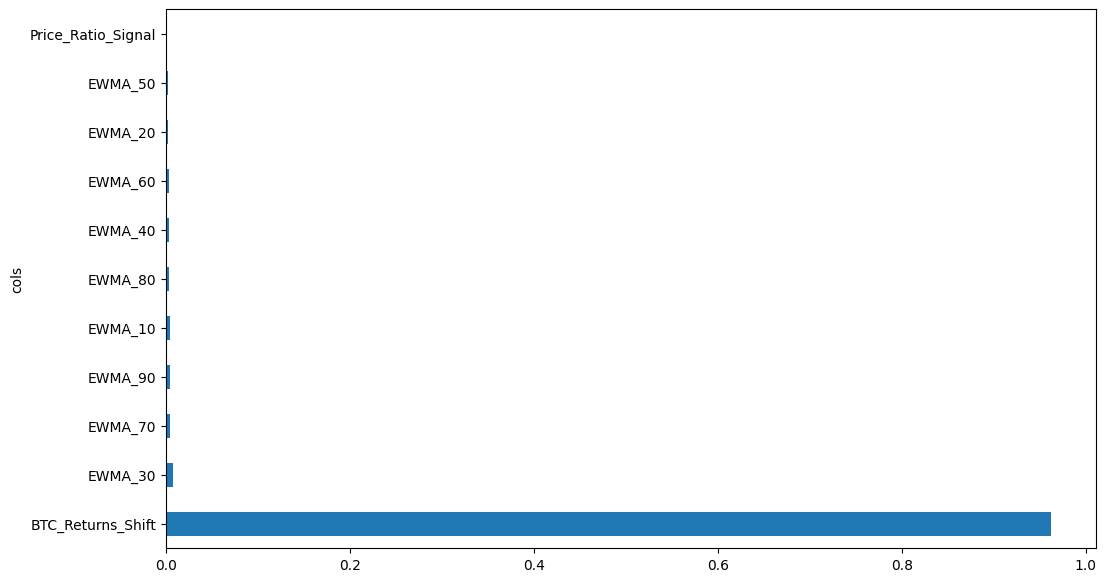

In [22]:
plot_fi(fi)